In [5]:
import os, shutil
from glob import glob
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

In [ ]:
def clean_train_test(clss):
    tst = "./output/test/" + clss + "/*"
    train = "./output/train/" + clss + "/*"
    tst_files, train_files = glob(tst), glob(train)
    for f in tst_files:
        os.remove(f)
    for f in train_files:
        os.remove(f)

def create_train_test():
    rootdir = "./output"
    if not os.path.exists(rootdir):
        os.makedirs(rootdir)
        os.makedirs(rootdir + "/train")
        os.makedirs(rootdir + "/test")

    classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora", "ragno", "scoiattolo"]
    for clss in classes:
        clss_source = "./animals10/raw-img/" + clss
        clean_train_test(clss)

        
        allFileNames = os.listdir(clss_source)
        np.random.shuffle(allFileNames)
        test_ratio = 0.3
        train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - test_ratio))])
        train_FileNames = [clss_source+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [clss_source+'/' + name for name in test_FileNames.tolist()]

        for name in train_FileNames:
            shutil.copy(name, rootdir +'/train/' + clss)

        for name in test_FileNames:
            shutil.copy(name, rootdir +'/test/' + clss)

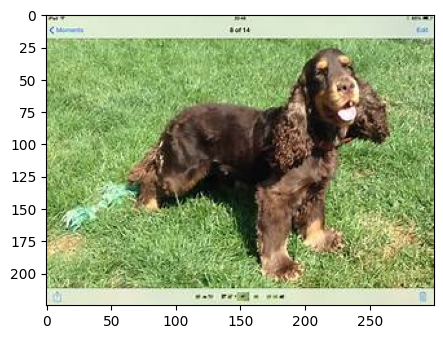

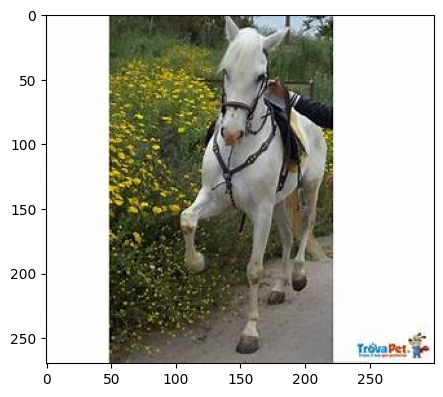

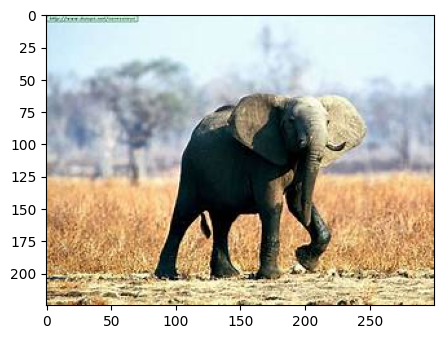

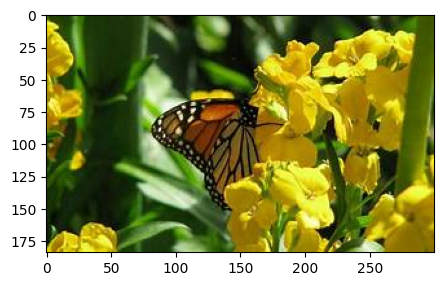

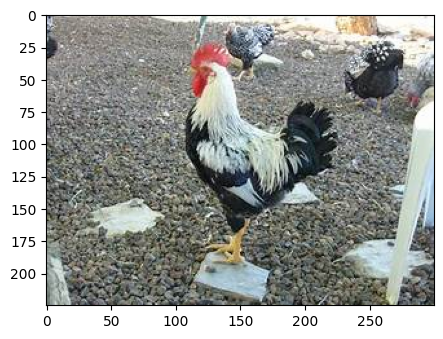

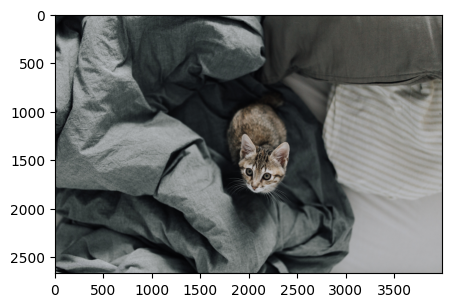

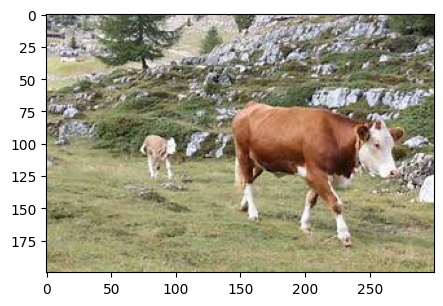

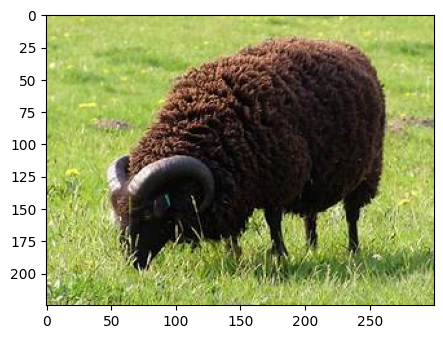

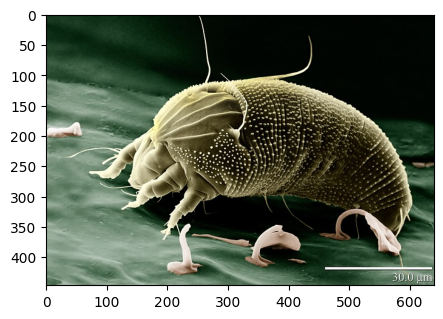

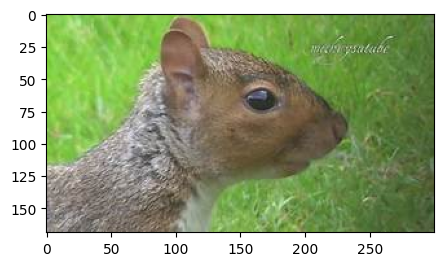

In [7]:
train_dir = "./output/train"
test_dir = "./output/test"

training_ds = train = ImageFolder(train_dir)
test = ImageFolder(test_dir)

for path in os.listdir(train_dir):
    temp_path = os.path.join(train_dir, path)
    file = random.choice(os.listdir(temp_path))
    img_path = os.path.join(temp_path, file)

    img = mpimg.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)